In [200]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import scienceplots


plt.style.use([
    'science',
    'notebook',
    'grid',
    'retro'
])

In [201]:
mu = 950
ms = 15

kt = 5000  # N/m
ks = 15000 # N/m

N = 2

M = sp.Matrix([
    [mu, 0],
    [0, ms],
])

K = sp.Matrix([
    [kt+ks, -ks],
    [-ks, ks],
])

# Condições Iniciais
X0 = sp.Matrix([
    [.5],
    [.0]
])

V0 = sp.Matrix([
    [0.],
    [0.]
])

In [202]:
# Calculando M á menos meio
M_minus_half = sp.zeros(N, N)
M_half = sp.zeros(N, N)


for i in range(N):
    M_minus_half[i, i] = (1/sp.sqrt(M[i, i])).evalf()
    M_half[i, i] = (sp.sqrt(M[i, i])).evalf()


# Calculando Ktil
K_til = M_minus_half @ K @ M_minus_half

# Calculando Ctil
# C_til = M_minus_half @ C @ M_minus_half

# Encontrando as frequências naturais e amortecidas
lmbd = sp.symbols('lambda')

expr_wn = (K_til - lmbd*sp.eye(N))

eig_wn = sp.solve(expr_wn.det(), lmbd)
wn = [sp.sqrt(eig_wn[i]) for i in range(N)]

In [203]:
# Encontrando os auto-vetores normalizados no unitário
a, b = sp.symbols('a b')

X = sp.Matrix([
    [a],
    [b]
])

norm_eq = sp.Eq(
    a**2+b**2,
    1
)

eigvecs = []
for i in range(N):
    sys_wn = expr_wn.subs(lmbd, eig_wn[i])
    sys = sys_wn @ X
    
    sol = sp.solve(
        [sys[0], norm_eq],
        [a, b],
        dict=True
    )[0]

    eigvecs.append(np.array([
        sol[a],
        sol[b],
    ]))

# Matriz P
P = sp.zeros(N,N)

P[:, 0] = eigvecs[0]
P[:, 1] = eigvecs[1]

# diag_  = P.T @ C_til @ P
# zetas  = [diag_[i, i] / (2*wn[i]) for i in range(N)]

zetas = [0.1, 0.1]

wds = [wn[i] * sp.sqrt(1 - zetas[i]**2) for i in range(N)]

# matrix spectral de P
S = M_minus_half @ P
S_inv = S.inv()

In [204]:
diag_ = np.diag([2*zetas[i]*wn[i] for i in range(N)])
C = M_half @ (P.T @ diag_ @ P) @ M_half
C

Matrix([
[ 520.779435363791, -87.8505411152646],
[-87.8505411152646,  94.2238892291085]])

In [205]:
wds

[2.26475571895821, 31.7129782076141]

In [206]:
wn

[2.27616513987757, 31.8727423331435]

In [207]:
sp.pprint(P)

⎡-0.99211702039895   -0.125314874754394⎤
⎢                                      ⎥
⎣-0.125314874754393   0.99211702039895 ⎦


In [208]:
sp.pprint(S)

⎡-0.0321885265954271  -0.00406575141429625⎤
⎢                                         ⎥
⎣-0.0323561615303889    0.25616351316627  ⎦


In [209]:
# condições iniciais inversas modais
r_0 = S_inv @ X0
r_dot_0 = S_inv @ V0

sp.pprint(r_0)
print(' ')
sp.pprint(r_dot_0)

⎡-15.2895501328279⎤
⎢                 ⎥
⎣-1.93123192179072⎦
 
⎡0⎤
⎢ ⎥
⎣0⎦


In [210]:
# Calculando as soluções modais desacopladas
t = sp.symbols('t')

r = []

forced_response_forces = sp.Matrix([
    [.0],
    [.0]
])

B = sp.Matrix([
    [0, 0],
    [0, 1]
])

F = P.T @ M_minus_half @ B @ forced_response_forces
wf = 17

for i in range(2):
    w = wn[i]
    wd = wds[i]
    zeta = zetas[i]
    
    r_zero = r_0[i]
    rdot_zero = r_dot_0[i]

    Ai = sp.sqrt(
        ((r_zero * wd)**2 + (rdot_zero + zeta*w*r_zero)**2) / wd**2
    )

    phi_i = sp.atan(
        (r_zero*wd) / (rdot_zero + zeta*w*r_zero)
    )

    if rdot_zero == 0:
        phi_i = sp.pi/2
    
    expr_r = Ai*sp.exp(-zeta*w*t)*sp.sin(wd*t + phi_i)

    f0 = F[i]
    A0 = f0 / sp.sqrt( (w**2 - wf**2)**2 + (2*zeta*w*wf)**2 )
    theta = sp.atan( (2*zeta*w*wf) / (w**2 - wf**2) )
    
    if (w**2 - wf**2) == 0:
        theta = sp.pi/2

    expr_r += A0*sp.cos(wf*t - theta)
    
    r.append(
        expr_r
    )

R = sp.Matrix(r)
sp.pprint(F)

⎡0⎤
⎢ ⎥
⎣0⎦


In [211]:
# Retornando ao dominio fisico
x_t = S @ sp.Matrix(r)
x_t.evalf()

x_t

Matrix([
[-0.00789146538391247*exp(-3.18727423331435*t)*cos(31.7129782076141*t) - 0.494627442245694*exp(-0.227616513987757*t)*cos(2.26475571895821*t)],
[   0.497203417224399*exp(-3.18727423331435*t)*cos(31.7129782076141*t) - 0.497203417224399*exp(-0.227616513987757*t)*cos(2.26475571895821*t)]])

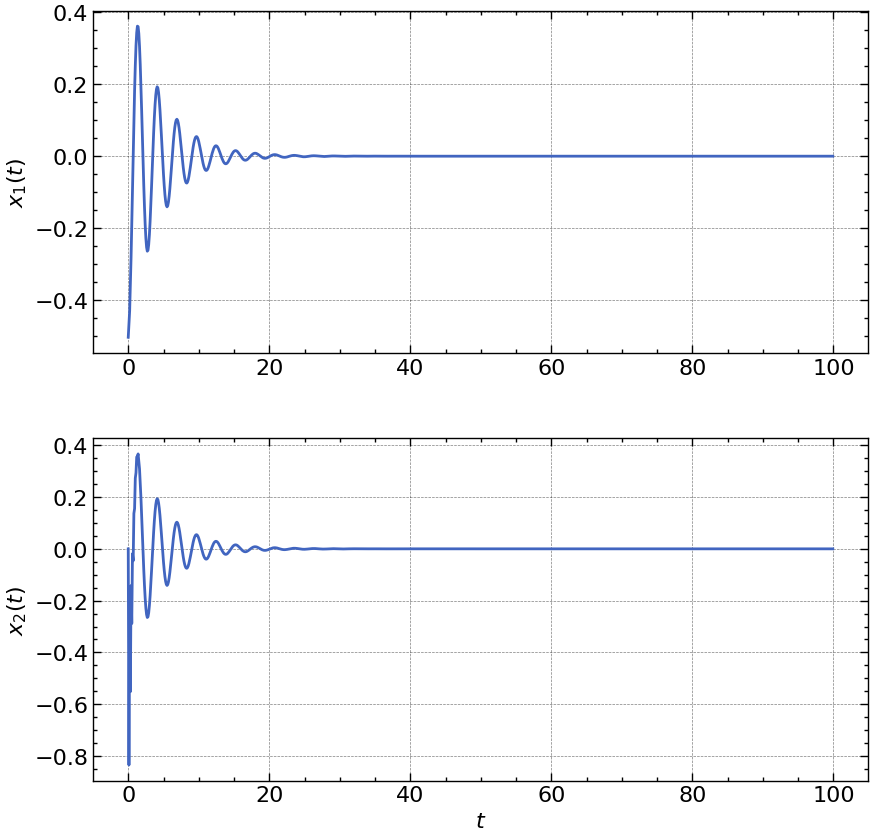

In [212]:
# Simulação

sampling_period = 1e-1
samples = 10000

time = np.arange(0, samples*sampling_period, sampling_period)

x1_t = sp.lambdify(t, x_t[0])
x2_t = sp.lambdify(t, x_t[1])

x1 = x1_t(time)
x2 = x2_t(time)

fig, ax = plt.subplots(2, 1, figsize=(10, 10))
plt.subplots_adjust(hspace=0.25)

idx = int(100 / .1)

ax[0].plot(time[:idx], x1[:idx])
ax[0].set_ylabel('${x}_1(t)$')

ax[1].plot(time[:idx], x2[:idx])
ax[1].set_xlabel('$t$')
ax[1].set_ylabel('${x}_2(t)$')

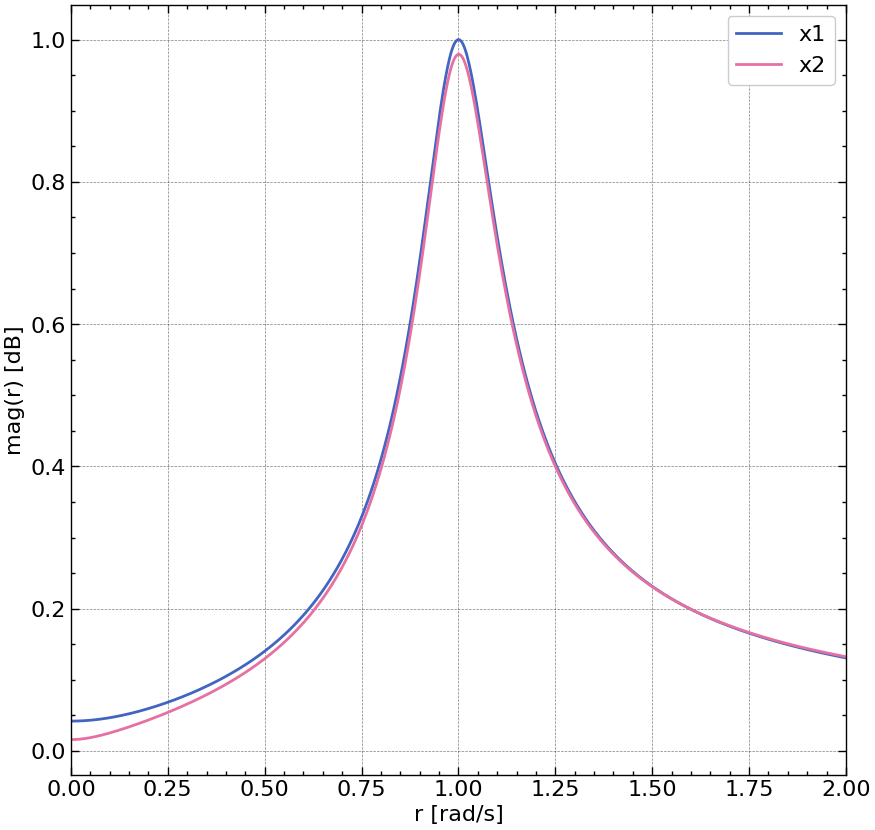

In [213]:
def fft(signal, sampling_time):
    fft = np.fft.fft(signal)
    N = signal.shape[0]

    f = np.fft.fftfreq(len(signal), sampling_time)

    K = N // 2

    freqs = f[:K]*2*np.pi
    amplitudes = np.abs(fft)[:K] * (1 / N)

    phase = np.rad2deg(np.angle(fft)[:K])

    return freqs, amplitudes, phase


fft_x1 = fft(x1, sampling_period)
fft_x2 = fft(x2, sampling_period)

maximum_amp = np.max([fft_x1[1], fft_x2[1]])
maximum_freq = np.max(
    [fft_x1[0][np.argmax(fft_x1[1])], fft_x2[0][np.argmax(fft_x2[1])]]
)

plt.figure(figsize=(10, 10))
plt.plot(
    fft_x1[0]/maximum_freq,
    fft_x1[1]/maximum_amp,
    label='x1'
)

plt.plot(
    fft_x2[0]/maximum_freq,
    fft_x2[1]/maximum_amp,
    label='x2'
)

plt.xlim(0, 2)
plt.xlabel('r [rad/s]')
plt.ylabel('mag(r) [dB]')
plt.legend()